In [1]:
import pathlib
import sys
import os

# Hacky way to get to root package
if "notebooks" in os.getcwd():
    os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2
    
import sys
from data_container import load_scouted_data, get_Teams_in_Match, load_pit_data
import pandas as pd
import numpy as np
import plotly.express as px
pd.set_option('display.max_columns', None)

In [3]:
scouted_data = load_scouted_data()
scouted_data

,Scouter Initials,Match Number,Team Number,No Show,Auto Fuel,Auto Climbing Status,Auto Human Player Score,Teleop Fuel,Teleop Human Player Score,Endgame Climbing Level
0,abc,1,1678,False,14,True,12,49,6,L1
1,abc,1,3504,True,15,True,10,20,3,NaN
2,abc,1,8393,False,13,False,6,152,8,L2
3,abc,1,118,True,9,True,2,175,5,L1
4,abc,1,254,True,4,False,3,12,18,L3
5,abc,1,67,False,12,True,16,98,13,L1
6,abc,2,8393,False,7,False,10,190,8,L1
7,abc,2,67,True,15,True,7,144,30,L2
8,abc,2,118,True,3,True,14,64,26,NaN
9,abc,2,1678,False,2,False,1,198,0,L2


In [4]:
teams = get_Teams_in_Match()
match_data = scouted_data.loc[scouted_data["Team Number"].isin(teams)].reset_index()
match_data

,index,Scouter Initials,Match Number,Team Number,No Show,Auto Fuel,Auto Climbing Status,Auto Human Player Score,Teleop Fuel,Teleop Human Player Score,Endgame Climbing Level
0,0,abc,1,1678,False,14,True,12,49,6,L1
1,1,abc,1,3504,True,15,True,10,20,3,NaN
2,2,abc,1,8393,False,13,False,6,152,8,L2
3,3,abc,1,118,True,9,True,2,175,5,L1
4,4,abc,1,254,True,4,False,3,12,18,L3
5,5,abc,1,67,False,12,True,16,98,13,L1
6,6,abc,2,8393,False,7,False,10,190,8,L1
7,7,abc,2,67,True,15,True,7,144,30,L2
8,8,abc,2,118,True,3,True,14,64,26,NaN
9,9,abc,2,1678,False,2,False,1,198,0,L2


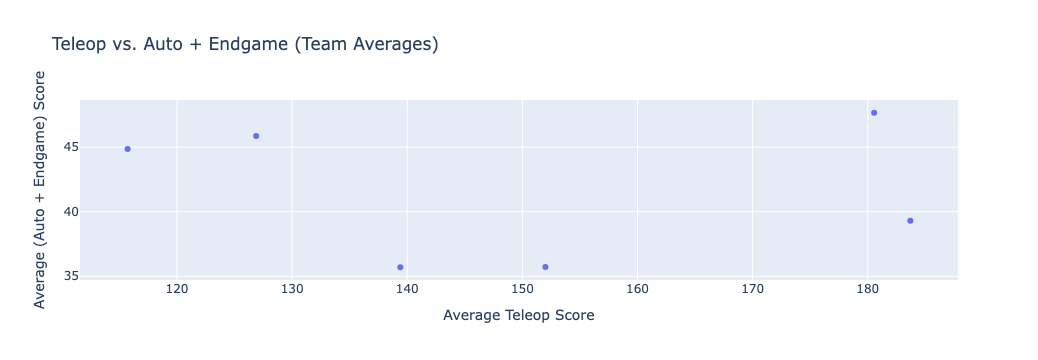

In [63]:
scouted_data = load_scouted_data()
teams = get_Teams_in_Match()
match_data = scouted_data.loc[scouted_data["Team Number"].isin(teams)].reset_index()

# Convert numeric columns, filling NaN with 0
numeric_cols = ["Auto Fuel", "Auto Human Player Score", "Teleop Fuel", "Teleop Human Player Score"]
for col in numeric_cols:
    if col in match_data.columns:
        match_data[col] = pd.to_numeric(match_data[col], errors='coerce').fillna(0)

# Handle boolean column
match_data["Auto Climbing Status"] = match_data["Auto Climbing Status"].fillna(False)
if match_data["Auto Climbing Status"].dtype == 'object':
    match_data["Auto Climbing Status"] = match_data["Auto Climbing Status"].astype(str).str.lower().isin(['true', '1', 'yes'])

# Convert Endgame Climbing Level for teleop
def convert_endgame_to_teleop(level):
    if pd.isna(level):
        return 0
    level_str = str(level).upper().strip()
    if level_str == "L1":
        return 10
    elif level_str == "L2":
        return 20
    elif level_str == "L3":
        return 30
    else:
        return 0

match_data["Endgame Teleop Points"] = match_data["Endgame Climbing Level"].apply(convert_endgame_to_teleop)

# Calculate scores
match_data["Auto Climb Points"] = match_data["Auto Climbing Status"].apply(lambda x: 15 if x else 0)
match_data["All Auto"] = match_data["Auto Fuel"] + match_data["Auto Human Player Score"] + match_data["Auto Climb Points"]
match_data["All Teleop"] = match_data["Teleop Fuel"] + match_data["Teleop Human Player Score"] + match_data["Endgame Teleop Points"]
match_data["All Endgame"] = match_data["Endgame Teleop Points"]
match_data["Auto and Endgame"] = match_data["All Auto"] + match_data["All Endgame"]

# Group by Team Number
team_stats = match_data.groupby("Team Number").agg({
    "All Teleop": "mean",
    "Auto and Endgame": "mean",
    "All Auto": "mean",
    "All Endgame": "mean",
    "Endgame Teleop Points": "mean",
    "Auto Climb Points": "mean",
    "Auto Climbing Status": "mean",
}).reset_index()

# Create plot with Team Number bold at the top
fig = px.scatter(
    team_stats, 
    x="All Teleop", 
    y="Auto and Endgame", 
    title="Teleop vs. Auto + Endgame (Team Averages)",
    hover_data={
        "Team Number": True,
        "All Teleop": ":.1f",
        "Auto and Endgame": ":.1f",
        "All Auto": ":.1f",
        "All Endgame": ":.1f",
        "Endgame Teleop Points": ":.1f",
        "Auto Climb Points": ":.1f",
        "Auto Climbing Status": ":.2%",
    }
)

# Update hover template to make Team Number bold at the top
fig.update_traces(
    hovertemplate=(
        "<b>Team %{customdata[0]}</b><br>"
        "All Teleop: %{x:.1f}<br>"
        "Auto and Endgame: %{y:.1f}<br>"
        "All Auto: %{customdata[1]:.1f}<br>"
        "All Endgame: %{customdata[2]:.1f}<br>"
        "Endgame Teleop Points: %{customdata[3]:.1f}<br>"
        "Auto Climb Points: %{customdata[4]:.1f}<br>"
        "Auto Climbing Status: %{customdata[5]:.2%}<extra></extra>"
    ),
    customdata=team_stats[["Team Number", "All Auto", "All Endgame", 
                          "Endgame Teleop Points", "Auto Climb Points", 
                          "Auto Climbing Status"]].values
)

fig.update_layout(
    xaxis_title="Average Teleop Score",
    yaxis_title="Average (Auto + Endgame) Score",
    hovermode="closest",
    showlegend=False
)

fig.show()